# Updates from last version  

* 04/07 - Initial version - Visualization of word embedding
* 05/07 - trying better word embedding visualization with more instances of accurate and inaccurate predictions
* 06/07 - updating reference input for SHAP from `<PAD>` to `<UNK>`
* 07/07 - Trying to plot words for two different entities together 
* 20/07 - used the last epoch mode and 5 words per explanation
* 26/07 - split expression change for LIME-NER

In [1]:
%env PYTHONHASHSEED=0

env: PYTHONHASHSEED=0


In [2]:
import pandas as pd
import collections
import pickle

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import load_model
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy, crf_marginal_accuracy, crf_viterbi_accuracy

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

from ner_util import pre_process_data_ner, \
                        iob_to_iob2,\
                        SentenceGetter, \
                        format_aux_input, \
                        reduce_sentence_length_by_word, \
                        pred2label, \
                        sent2features, \
                        get_f1

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
# file paths
validation_iob_tagged_file = '../data/CoNLL-2003/eng.testa'
save_best_weights = '../models/ner/bi_lstm_crf_last_epoch_weights.h5'
# '../models/ner/bi_lstm_crf_weights.h5'
vocab2int_path = '../models/ner_bilstm_crf_train_vocab2int.pkl'
# oh_encoder_path = '../models/ner_bilstm_crf_trained_oh_encoder.pkl'
# standard_transformer_path = '../models/ner_bilstm_crf_trained_standard_transform.pkl'
preprocess_transformer_path = '../models/ner_bilstm_crf_trained_pre-proc_transform.pkl'
tag2idx_path = '../models/ner_bilstm_crf_tag2idx.pkl'
idx2tag_path = '../models/ner_bilstm_crf_idx2tag.pkl'
moldel_outout_path = '../models/'
trained_embedding_tsne_model_path = '../models/ner_bilstm_crf_trained_word_embedding_tsne.pkl'

In [4]:
# other configurations
max_words = 25
max_len = 25
n_tags = 9
num_word_prev = 5
num_word_next = 5

## Load models

In [5]:
with (open(vocab2int_path, "rb")) as _openfile:
    vocab_to_int = pickle.load(_openfile)

In [6]:
with (open(preprocess_transformer_path, "rb")) as _openfile:
    trained_preprocess_transform = pickle.load(_openfile)

In [7]:
with (open(tag2idx_path, "rb")) as _openfile:
    tag2idx = pickle.load(_openfile)

In [8]:
tag2idx

{'B-PER': 0,
 'B-ORG': 1,
 'I-PER': 2,
 'B-MISC': 3,
 'I-ORG': 4,
 'I-LOC': 5,
 'I-MISC': 6,
 'O': 7,
 'B-LOC': 8}

In [9]:
with (open(idx2tag_path, "rb")) as _openfile:
    idx2tag = pickle.load(_openfile)

In [10]:
idx2tag

{0: 'B-PER',
 1: 'B-ORG',
 2: 'I-PER',
 3: 'B-MISC',
 4: 'I-ORG',
 5: 'I-LOC',
 6: 'I-MISC',
 7: 'O',
 8: 'B-LOC'}

In [11]:
import numpy as np
import tensorflow as tf
import random as python_random

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.set_random_seed(1234)

In [12]:
model = load_model(save_best_weights,custom_objects={'CRF': CRF,
                               'crf_loss': crf_loss,
                               'crf_viterbi_accuracy': crf_viterbi_accuracy,
                                'crf_marginal_accuracy':crf_marginal_accuracy,
                                'get_f1': get_f1})

### word embedding matrix

In [13]:
# https://stackoverflow.com/questions/51235118/how-to-get-word-vectors-from-keras-embedding-layer
# or access the embedding layer through the constructed model 
# first `1` refers to the position of embedding layer in the `model`
embeddings = model.layers[1].get_weights()[0]

# `embeddings` has a shape of (num_vocab, embedding_dim) 

# `word_to_index` is a mapping (i.e. dict) from words to their index, e.g. `love`: 69
words_embeddings = {w:embeddings[idx] for w, idx in vocab_to_int.items()}

# now you can use it like this for example
print(words_embeddings['Lanka'])  # possible output: [0.21, 0.56, ..., 0.65, 0.10]

[-3.36740166e-01  2.18731061e-01  6.27949297e-01  3.37669373e-01
  3.86475086e-01  4.79547027e-03 -3.24348003e-01  3.39700341e-01
  2.55318850e-01  1.94240832e+00 -6.80431843e-01 -2.59622008e-01
 -1.59843624e-01 -1.42610624e-01  3.53444874e-01 -1.38588697e-01
 -2.16480747e-01 -1.71010524e-01  1.80353805e-01  6.39198482e-01
 -4.90166783e-01  4.10335600e-01  5.01924232e-02  2.98806399e-01
  4.99295712e-01 -4.60477740e-01  5.12212992e-01 -5.99256873e-01
 -9.80546832e-01  5.56439981e-02  3.31616700e-01 -8.52827311e-01
 -2.32758075e-01 -6.51850522e-01 -4.21849191e-01 -1.26298890e-01
  6.72435015e-02 -6.87169749e-03 -5.26970103e-02 -3.68533373e-01
 -5.03058471e-02 -5.51537037e-01  3.06367993e-01 -4.80992138e-01
  2.72348393e-02 -2.61358947e-01 -1.01259060e-01  8.99245024e-01
 -3.47178340e-01 -1.68612629e-01  4.29267615e-01 -3.08235109e-01
 -3.41207027e-01  2.35611632e-01  3.24770451e-01  6.30351901e-01
 -3.20179760e-02  6.53528124e-02  5.99081755e-01 -3.53735238e-01
 -9.67708290e-01 -6.62162

In [14]:
# copied from https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_transform(words_embeddings):
    "Creates and TSNE model"
    labels = []
    tokens = []

    for word, vector in words_embeddings.items():
        tokens.append(vector)
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

#     x = []
#     y = []
    tsne_dict = {}
    for i, value in enumerate(new_values):
#         x.append(value[0])
#         y.append(value[1])
        tsne_dict[labels[i]] = [value[0], value[1]]
    return tsne_dict

In [15]:
tsne_model_dict = tsne_transform(words_embeddings)

In [16]:
with open(trained_embedding_tsne_model_path,'wb') as _f:
    pickle.dump(tsne_model_dict,_f,protocol = pickle.HIGHEST_PROTOCOL)

## Hold out dataset

In [17]:
validate_iob_tag_df = pd.read_csv(validation_iob_tagged_file,delimiter=' ',skip_blank_lines=False, 
                                  header = None, names = ['word','pos','chunk','tag'])
validate_iob_tag_df.head()

,word,pos,chunk,tag
0,-DOCSTART-,-X-,O,O
1,NaN,NaN,NaN,NaN
2,CRICKET,NNP,I-NP,O
3,-,:,O,O
4,LEICESTERSHIRE,NNP,I-NP,I-ORG


In [18]:
validate_iob_tagged_df_cleaned = pre_process_data_ner(validate_iob_tag_df)
validate_iob_tagged_df_cleaned.isna().sum()

word            0
pos             0
chunk           0
tag             0
sentence_num    0
doc_num         0
dtype: int64

In [19]:
validate_tag_counts = collections.Counter(validate_iob_tagged_df_cleaned["tag"])
validate_tag_counts

Counter({'O': 42120,
         'I-ORG': 2092,
         'I-LOC': 2094,
         'I-MISC': 1264,
         'I-PER': 3145,
         'B-MISC': 4})

In [20]:
validate_iob_tagged_df_cleaned["iob2_tag"] = iob_to_iob2(validate_iob_tagged_df_cleaned)
validate_iob_tagged_df_cleaned["iob2_chunk"] = iob_to_iob2(validate_iob_tagged_df_cleaned,'chunk')
validate_iob_tagged_df_cleaned.head()

,word,pos,chunk,tag,sentence_num,doc_num,iob2_tag,iob2_chunk
2,CRICKET,NNP,I-NP,O,0,0,O,B-NP
3,-,:,O,O,0,0,O,O
4,LEICESTERSHIRE,NNP,I-NP,I-ORG,0,0,B-ORG,B-NP
5,TAKE,NNP,I-NP,O,0,0,O,I-NP
6,OVER,IN,I-PP,O,0,0,O,B-PP


In [21]:
validate_iob_tagged_df_cleaned.drop(['chunk','tag'], axis = 1, inplace = True)
validate_iob_tagged_df_cleaned.rename(columns = {'iob2_tag':'tag',
                                              'iob2_chunk':'chunk'}, inplace = True)

In [22]:
validate_iob_tagged_df_cleaned_reduced = reduce_sentence_length_by_word(validate_iob_tagged_df_cleaned,
                                                                     max_words,'sentence_num')
validate_iob_tagged_df_cleaned_reduced.shape

(24988, 6)

In [23]:
validate_tag_counts = collections.Counter(validate_iob_tagged_df_cleaned_reduced["tag"])
validate_tag_counts

Counter({'O': 20121,
         'B-ORG': 839,
         'B-LOC': 1180,
         'B-PER': 1008,
         'I-PER': 675,
         'B-MISC': 460,
         'I-MISC': 193,
         'I-LOC': 156,
         'I-ORG': 356})

In [24]:
validate_getter = SentenceGetter(validate_iob_tagged_df_cleaned_reduced)
validate_sentences = validate_getter.sentences

In [25]:
X_validate = [[vocab_to_int[w[0]] if w[0] in vocab_to_int.keys() else vocab_to_int['<UNK>'] for w in s]\
                                                            for s in validate_sentences]
X_validate = pad_sequences(maxlen = max_len, sequences = X_validate, 
                        padding  = 'post', value = vocab_to_int['<PAD>'])
len(X_validate[0])

25

In [26]:
y_validate = [[tag2idx[w[3]] for w in s] for s in validate_sentences]
y_validate = pad_sequences(maxlen = max_len, sequences = y_validate, padding  = 'post', value = tag2idx['O'])

In [27]:
y_validate = [to_categorical(i, num_classes = n_tags) for i in y_validate]

In [28]:
X_aux_validate =  [sent2features(s, num_word_prev, num_word_next, max_len) for s in validate_sentences]
len(X_aux_validate), len(X_aux_validate[0])

(2505, 25)

In [29]:
aux_validate_input, _ = format_aux_input(X_aux_validate, max_len = max_len,
                                     preproc_transform = trained_preprocess_transform)
              #oh_encoder = trained_oh_encoder, standard_transform = trained_standard_transform)
aux_validate_input.shape

D:\Anaconda\envs\XAI_NER\lib\site-packages\pandas\core\frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


(2505, 25, 2684)

In [30]:
validate_pred = model.predict([X_validate,aux_validate_input], verbose=1)

2505/2505 [==============================] - 10s 4ms/step


In [31]:
validate_pred.shape

(2505, 25, 9)

In [32]:
validate_pred_labels = pred2label(validate_pred, idx2tag)
validate_labels = pred2label(y_validate, idx2tag)

In [33]:
print("F1-score: {:.1%}".format(f1_score(validate_labels, validate_pred_labels)))
print(classification_report(validate_labels, validate_pred_labels))

F1-score: 81.4%
           precision    recall  f1-score   support

      PER       0.72      0.86      0.78      1008
      LOC       0.93      0.86      0.89      1180
      ORG       0.77      0.80      0.79       839
     MISC       0.70      0.79      0.74       460

micro avg       0.79      0.83      0.81      3487
macro avg       0.80      0.83      0.82      3487



## Prepare for explanation

We'll choose observations where there is at least one predicted entity of type location (best performing) or misc (worst performing) and where the probability score is more than 0.95.  
Then we'll need to choose the pair of tags for comparison. The output of this activity should be a data frame containing:
- sentence in raw form
- word index in the sentence for B-LOC / I-LOC tag (having probability more than 0.95)
- whether the prediction is correct
- the other tag for comparison
- word index in the sentence for B-MISC / I-MISC tag (having probability more than 0.95)
- whether the prediction is correct
- the other tag for comparison

In [34]:
import numpy as np
import random
from explanation_util import get_entity_prediction, \
                            get_explanation_instances

In [35]:
validate_entity_prob_mat, idx2ent = get_entity_prediction(validate_pred, idx2tag)
validate_true_entity_prob_mat, idx2ent_true = get_entity_prediction(y_validate, idx2tag)
validate_pred.shape, validate_entity_prob_mat.shape, validate_true_entity_prob_mat.shape, len(idx2ent)

((2505, 25, 9), (2505, 25, 5), (2505, 25, 5), 5)

In [36]:
expl_selected_dict = get_explanation_instances(validate_entity_prob_mat, validate_true_entity_prob_mat, idx2ent, idx2ent_true)

In [37]:
print_dict = {k:v for i,(k,v) in enumerate(expl_selected_dict.items()) if i < 5}
print_dict

{(1, 'LOC', 0.9995532631874084): {'word_indx': [0],
  'p_i': 1,
  'p_i_next': 2,
  'pred_tag_next': 'ORG',
  'p_next': 4.795094355358742e-05,
  'is_accurate': True,
  'actual_tag': ['LOC']},
 (3, 'LOC', 0.9628937244415283): {'word_indx': [5],
  'p_i': 1,
  'p_i_next': 2,
  'pred_tag_next': 'ORG',
  'p_next': 0.03453490883111954,
  'is_accurate': True,
  'actual_tag': ['LOC']},
 (6, 'MISC', 0.9971410830815634): {'word_indx': [2, 3, 4],
  'p_i': 3,
  'p_i_next': 4,
  'pred_tag_next': 'O',
  'p_next': 0.0008483295511420389,
  'is_accurate': True,
  'actual_tag': ['MISC', 'MISC', 'MISC']},
 (7, 'LOC', 0.9995532631874084): {'word_indx': [0],
  'p_i': 1,
  'p_i_next': 2,
  'pred_tag_next': 'ORG',
  'p_next': 4.795094355358742e-05,
  'is_accurate': True,
  'actual_tag': ['LOC']},
 (8, 'MISC', 0.9996391534805298): {'word_indx': [7],
  'p_i': 3,
  'p_i_next': 4,
  'pred_tag_next': 'O',
  'p_next': 2.9310762329259887e-05,
  'is_accurate': True,
  'actual_tag': ['MISC']}}

In [38]:
# only multi word for explanation
expl_selected_multiword_dict = {key: expl_selected_dict[key] 
                                for key in expl_selected_dict.keys()
                                if len(expl_selected_dict[key]['word_indx']) > 1}

len(expl_selected_multiword_dict)

152

In [39]:
#create two different dict for correct and wrong predictions
expl_selected_multiword_accurate_dict = {key: expl_selected_multiword_dict[key] 
                                for key in expl_selected_multiword_dict.keys()
                                if expl_selected_multiword_dict[key]['is_accurate']}

len(expl_selected_multiword_accurate_dict)

151

In [40]:
#create two different dict for correct LOC and MISC predictions
expl_selected_multiword_accurate_dict_LOC = {key: expl_selected_multiword_accurate_dict[key] 
                                for key in expl_selected_multiword_accurate_dict.keys()
                                if key[1] == 'LOC'}

expl_selected_multiword_accurate_dict_MISC = {key: expl_selected_multiword_accurate_dict[key] 
                                for key in expl_selected_multiword_accurate_dict.keys()
                                if key[1] == 'MISC'}

len(expl_selected_multiword_accurate_dict_LOC), len(expl_selected_multiword_accurate_dict_MISC)

(69, 82)

In [41]:
# 35 random selection from each of correct prediction dict to limit computation
random.seed(32)
expl_accurate_random_multiword_keys_LOC = random.sample(expl_selected_multiword_accurate_dict_LOC.keys(),35)
expl_accurate_random_multiword_dict_LOC = {rnd_key: expl_selected_multiword_accurate_dict_LOC[rnd_key] for \
                                           rnd_key in expl_accurate_random_multiword_keys_LOC}
random.seed(32)
expl_accurate_random_multiword_keys_MISC = random.sample(expl_selected_multiword_accurate_dict_MISC.keys(),35)
expl_accurate_random_multiword_dict_MISC = {rnd_key: expl_selected_multiword_accurate_dict_MISC[rnd_key] for \
                                           rnd_key in expl_accurate_random_multiword_keys_MISC}

len(expl_accurate_random_multiword_dict_LOC),len(expl_accurate_random_multiword_dict_MISC)

(35, 35)

In [42]:
expl_selected_dict_08 = get_explanation_instances(validate_entity_prob_mat, validate_true_entity_prob_mat, idx2ent,
                                                  idx2ent_true, selection_prob = 0.8)

expl_selected_wrong_dict = {key: expl_selected_dict_08[key] 
                                for key in expl_selected_dict.keys()
                                if not expl_selected_dict[key]['is_accurate']}


len(expl_selected_wrong_dict)

14

In [43]:
#create two different dict for incorrect LOC and MISC predictions
expl_selected_wrong_dict_LOC = {key: expl_selected_wrong_dict[key] 
                                for key in expl_selected_wrong_dict.keys()
                                if key[1] == 'LOC'}

expl_selected_wrong_dict_MISC = {key: expl_selected_wrong_dict[key] 
                                for key in expl_selected_wrong_dict.keys()
                                if key[1] == 'MISC'}

len(expl_selected_wrong_dict_LOC), len(expl_selected_wrong_dict_MISC)

(9, 5)

In [44]:
index = 6
#label = tag2idx[index]
text = validate_sentences[index]
print(text)

[('CRICKET', 'NNP', 'B-NP', 'O'), ('-', ':', 'O', 'O'), ('ENGLISH', 'JJ', 'B-NP', 'B-MISC'), ('COUNTY', 'NNS', 'I-NP', 'I-MISC'), ('CHAMPIONSHIP', 'WDT', 'B-NP', 'I-MISC'), ('SCORES', 'NNP', 'I-NP', 'O'), ('.', '.', 'O', 'O')]


In [45]:
test_sent = " ".join([x[0] for x in text])
test_sent

'CRICKET - ENGLISH COUNTY CHAMPIONSHIP SCORES .'

In [46]:
sent_getter_id_dict = {" ".join([x[0] for x in text]):i for i, text in enumerate(validate_sentences)}

In [47]:
sent_word_getter_id_dict = {i:{(j,words[0]):words for j, words in enumerate(text)} for i, text in enumerate(validate_sentences)}

In [48]:
sent_word_getter_id_dict[10]

{(0, 'Somerset'): ('Somerset', 'NNP', 'B-NP', 'B-ORG'),
 (1, '83'): ('83', 'CD', 'I-NP', 'O'),
 (2, 'and'): ('and', 'CC', 'I-NP', 'O'),
 (3, '174'): ('174', 'CD', 'I-NP', 'O'),
 (4, '('): ('(', '(', 'O', 'O'),
 (5, 'P.'): ('P.', 'NNP', 'B-NP', 'B-PER'),
 (6, 'Simmons'): ('Simmons', 'NNP', 'I-NP', 'I-PER'),
 (7, '4-38'): ('4-38', 'CD', 'I-NP', 'O'),
 (8, ')'): (')', ')', 'O', 'O'),
 (9, ','): (',', ',', 'O', 'O'),
 (10, 'Leicestershire'): ('Leicestershire', 'NNP', 'B-NP', 'B-ORG'),
 (11, '296'): ('296', 'CD', 'I-NP', 'O'),
 (12, '.'): ('.', '.', 'O', 'O')}

## Kernel SHAP for NER

In [49]:
from explanation_util import NER_KSHAPExplainerGenerator
from matplotlib import pyplot as plt

In [50]:
KSHAP_explainer_generator = NER_KSHAPExplainerGenerator(model, vocab_to_int, tag2idx, max_len, 
                                            sent_getter_id_dict, sent_word_getter_id_dict,
                                            validate_sentences, trained_preprocess_transform,
                                                       num_word_next = num_word_next,
                num_word_prev = num_word_prev)

In [51]:
list(idx2ent.values())

['PER', 'LOC', 'ORG', 'MISC', 'O']

In [52]:
text = validate_sentences[159]
explian_text = " ".join([x[0] for x in text])
explian_text

'Amanda Coetzer ( South Africa ) beat Irina Spirlea ( Romania ) 7-6 ( 7-5 ) 7-5'

In [53]:
flat_input_list, flat_feature_list  = KSHAP_explainer_generator.preprocess([explian_text])


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 270ms/step


In [54]:
len(flat_feature_list[0])

67125

In [55]:
predict_func = KSHAP_explainer_generator.get_predict_function(word_index_list= [3, 4])
entity_pred_sample = predict_func(flat_input_list)
entity_pred_sample

array([[4.32064966e-05, 9.99240577e-01, 1.07696860e-04, 2.36876875e-04,
        3.33327765e-07]])

In [56]:
# ref_text = "<PAD>"
# changed from <PAD>
ref_text = ("<UNK> " * max_words).strip()
ref_flat_input, _ = KSHAP_explainer_generator.preprocess([ref_text])
ref_flat_input.shape, flat_input_list.shape

1/1 [==============================] - 0s 54ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


((1, 67125), (1, 67125))

### Kernel SHAP explanation

In [57]:
from explanation_validation_util import get_KSHAP_explanation_feature_list

In [58]:
KSHAP_expl_word_list_inaccurate_LOC = get_KSHAP_explanation_feature_list(KSHAP_explainer_generator, ref_flat_input,
                                                                         validate_sentences, expl_selected_wrong_dict_LOC)

1/1 [==============================] - 0s 39ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 286ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 278ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 266ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 267ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 280ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 266ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 223ms/step


In [59]:
KSHAP_expl_word_list_accurate_LOC = get_KSHAP_explanation_feature_list(KSHAP_explainer_generator, ref_flat_input,
                                                                       validate_sentences, expl_accurate_random_multiword_dict_LOC)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 263ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 284ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 272ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 259ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 273ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 221ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 265ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 230ms/step



1/1 [==============================] - 0s 81ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 280ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 267ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 283ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 247ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 301ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 237ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 269ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 270ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 377ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 275ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 287ms/step



1/1 [==============================] - 0s 94ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 233ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 289ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 280ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 270ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 285ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 297ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 272ms/step


In [60]:
KSHAP_expl_word_list_inaccurate_MISC = get_KSHAP_explanation_feature_list(KSHAP_explainer_generator, ref_flat_input,
                                                                          validate_sentences, expl_selected_wrong_dict_MISC)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 276ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 281ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 265ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 286ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 270ms/step


In [61]:
KSHAP_expl_word_list_accurate_MISC = get_KSHAP_explanation_feature_list(KSHAP_explainer_generator, ref_flat_input,
                                                                        validate_sentences, expl_accurate_random_multiword_dict_MISC)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 278ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 294ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 362ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 276ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 244ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 293ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 275ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 268ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 282ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 284ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 354ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 300ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 279ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 265ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 276ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 277ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 280ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 272ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 385ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 260ms/step



1/1 [==============================] - 0s 91ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 284ms/step



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1/1 [==============================] - 0s 301ms/step


## LIME set up for NER explanation

In [62]:
from lime.lime_text import LimeTextExplainer
from explanation_util import NER_LIMEExplainerGenerator

In [63]:
LIME_explainer_generator = NER_LIMEExplainerGenerator(model, vocab_to_int, tag2idx, max_len, 
                                            sent_getter_id_dict, sent_word_getter_id_dict,
                                            validate_sentences, trained_preprocess_transform,
                                                     num_word_next = num_word_next,
                num_word_prev = num_word_prev)

In [64]:
list(idx2ent.values())

['PER', 'LOC', 'ORG', 'MISC', 'O']

In [65]:
# classes and the entity names
LIME_explainer = LimeTextExplainer(class_names=list(idx2ent.values()),bow = False, split_expression= " ")


## Explanation qualitative metrics - Comprehensibility of explanation will be observed based on identity, separability and stability

In [66]:
from matplotlib import pyplot as plt
from explanation_validation_util import get_LIME_explanation_word_list

In [67]:
LIME_expl_word_list_inaccurate_LOC = get_LIME_explanation_word_list(LIME_explainer_generator, LIME_explainer, 
                                                                    validate_sentences, expl_selected_wrong_dict_LOC)

split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [68]:
LIME_expl_word_list_accurate_LOC = get_LIME_explanation_word_list(LIME_explainer_generator, LIME_explainer, 
                                                                  validate_sentences, expl_accurate_random_multiword_dict_LOC)

split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [69]:
LIME_expl_word_list_inaccurate_MISC = get_LIME_explanation_word_list(LIME_explainer_generator, LIME_explainer, 
                                                                     validate_sentences, expl_selected_wrong_dict_MISC)

split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [70]:
LIME_expl_word_list_accurate_MISC = get_LIME_explanation_word_list(LIME_explainer_generator, LIME_explainer, 
                                                                   validate_sentences, expl_accurate_random_multiword_dict_MISC)

split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
split() requires a non-empty pattern match.

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### LIME and KSHAP TSNE comparison

In [71]:
import itertools
def get_top_n_words(expl_dict_list, tsne_model_dict,
                    n=1, is_SHAP_feature = False):
    
     
    feature_list_key = 'explain_features' if is_SHAP_feature else 'explain_words'
            
    top_n_list = []
    top_n_list.extend([expl_dict[feature_list_key][0:n] for expl_dict in expl_dict_list])
    
    merged = list(itertools.chain(*top_n_list))
    top_n_set = set(merged)
    
    unique_feature_list = list(top_n_set)
    
    # if shap feature extract words from the feature
    if is_SHAP_feature:
        unique_feature_list = [feature.split('>')[0] for feature in unique_feature_list \
                               if feature.count('>') >= 3] # this means a word feature

    selected_word_tsne_dict ={k:tsne_model_dict.get(k,tsne_model_dict['<UNK>']) for k in unique_feature_list}
    
    return selected_word_tsne_dict

top_words_per_explaination = 5

In [72]:
def get_word_entity_dict(word_dict_list1, word_dict_list2, list1_entity, list2_entity):
    word_entity_dict = {}
    word_dict = {}
    for word, values in word_dict_list1.items():
        word_entity_dict[word] = list1_entity
        word_dict[word] = values
    
    for word in word_dict_list2.keys():
        if word in word_entity_dict.keys():
            word_entity_dict[word] = 'COMMON'
        else:
            word_entity_dict[word] = list2_entity
            word_dict[word] = values
            
    return word_dict, word_entity_dict    

In [73]:
def tsne_plot(tsne_transformed_dict, word_entity_dict = {},
             cdict = {'LOC': 'red', 'MISC': 'blue', 'COMMON': 'green', None:'grey'}):
    
    plt.figure(figsize=(16, 16))
    #ax = plt.gca()
    #fig, ax = plt.subplots()
    for label, x_y in tsne_transformed_dict.items():
        plt.scatter(x_y[0], x_y[1], c = cdict[word_entity_dict.get(label,None)], 
                   s = 100)
        plt.annotate(label,
                     xy=(x_y[0], x_y[1]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #ax.legend()
    plt.show()

In [74]:
# KSHAP top n words
KSHAP_top_n_words_inaccurate_LOC = get_top_n_words(KSHAP_expl_word_list_inaccurate_LOC,
                                            tsne_model_dict, top_words_per_explaination, True)
KSHAP_top_n_words_inaccurate_MISC = get_top_n_words(KSHAP_expl_word_list_inaccurate_MISC,
                                            tsne_model_dict, top_words_per_explaination, True)
KSHAP_top_n_words_accurate_LOC = get_top_n_words(KSHAP_expl_word_list_accurate_LOC,
                                            tsne_model_dict, top_words_per_explaination, True)
KSHAP_top_n_words_accurate_MISC = get_top_n_words(KSHAP_expl_word_list_accurate_MISC,
                                            tsne_model_dict, top_words_per_explaination, True)

In [75]:
# LIME top n words
LIME_top_n_words_inaccurate_LOC = get_top_n_words(LIME_expl_word_list_inaccurate_LOC,
                                            tsne_model_dict, top_words_per_explaination, False)
LIME_top_n_words_inaccurate_MISC = get_top_n_words(LIME_expl_word_list_inaccurate_MISC,
                                            tsne_model_dict, top_words_per_explaination, False)
LIME_top_n_words_accurate_LOC = get_top_n_words(LIME_expl_word_list_accurate_LOC,
                                            tsne_model_dict, top_words_per_explaination, False)
LIME_top_n_words_accurate_MISC = get_top_n_words(LIME_expl_word_list_accurate_MISC,
                                            tsne_model_dict, top_words_per_explaination, False)

#### LOC vs MISC

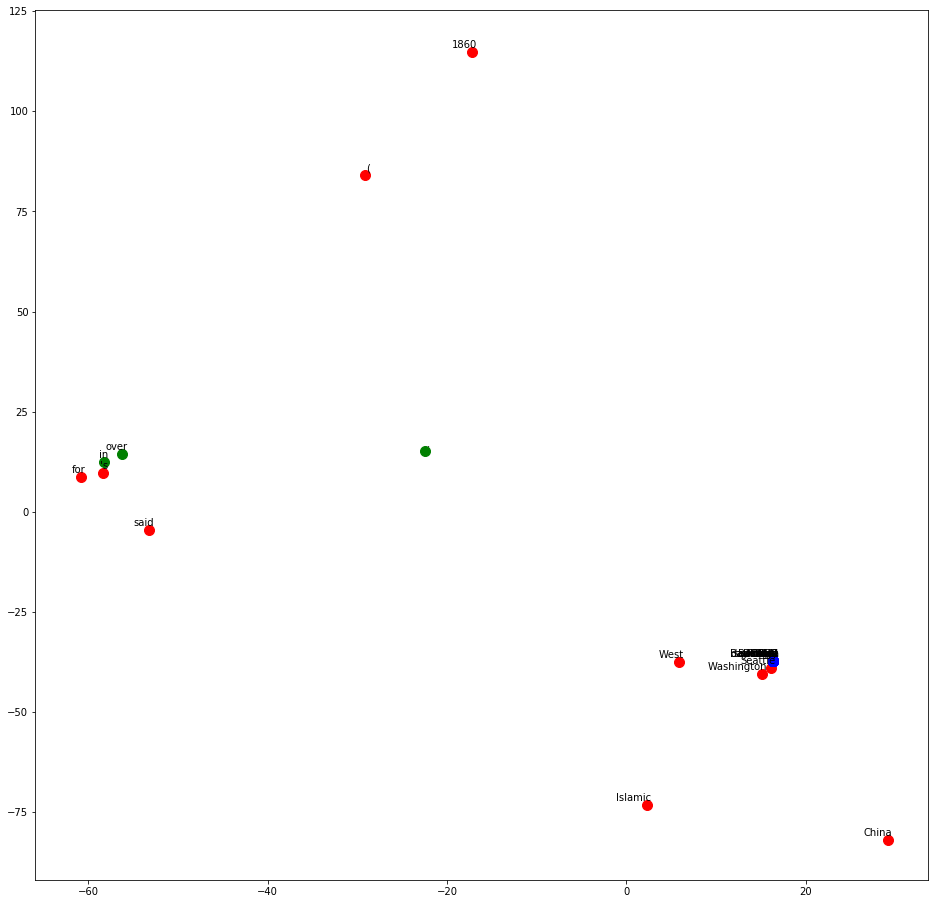

In [76]:
KSHAP_inaccurate_LOC_MISC_word_list, KSHAP_inaccurate_LOC_MISC_word_enity_list = get_word_entity_dict(KSHAP_top_n_words_inaccurate_LOC,
                                                                                          KSHAP_top_n_words_inaccurate_MISC,
                                                                                          'LOC', 'MISC')
tsne_plot(KSHAP_inaccurate_LOC_MISC_word_list, KSHAP_inaccurate_LOC_MISC_word_enity_list)

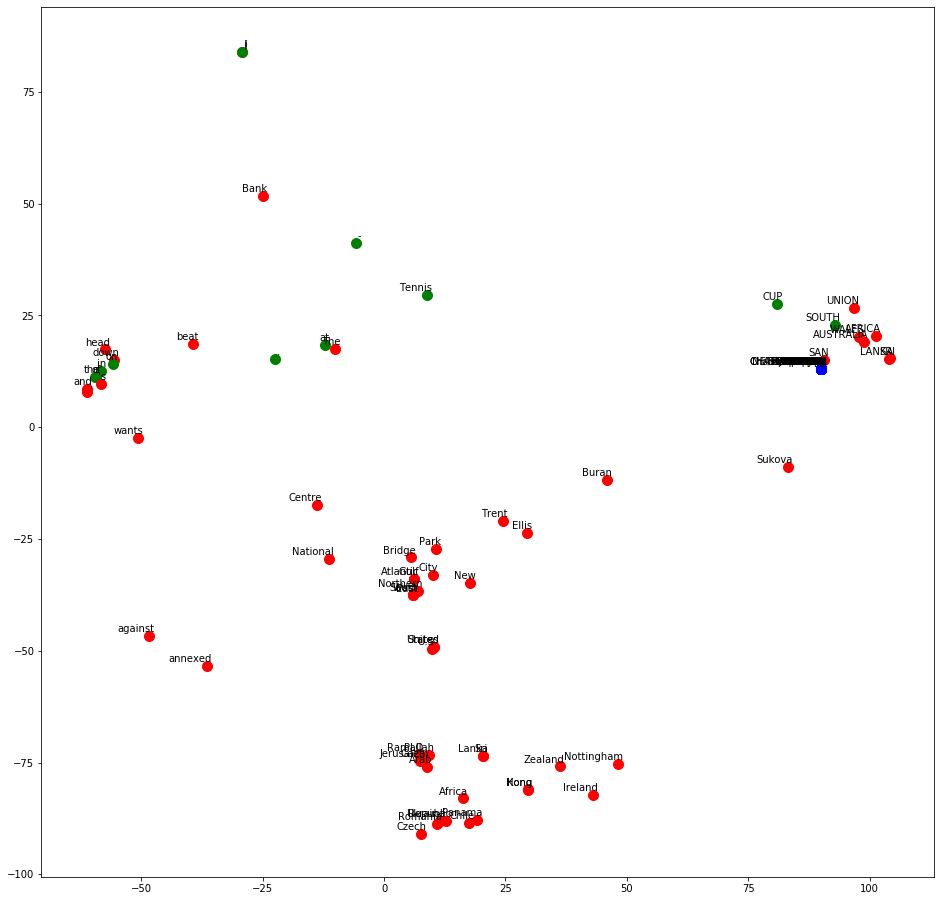

In [77]:
KSHAP_accurate_LOC_MISC_word_list, KSHAP_accurate_LOC_MISC_word_enity_list = get_word_entity_dict(KSHAP_top_n_words_accurate_LOC,
                                                                                          KSHAP_top_n_words_accurate_MISC,
                                                                                          'LOC', 'MISC')
tsne_plot(KSHAP_accurate_LOC_MISC_word_list, KSHAP_accurate_LOC_MISC_word_enity_list)

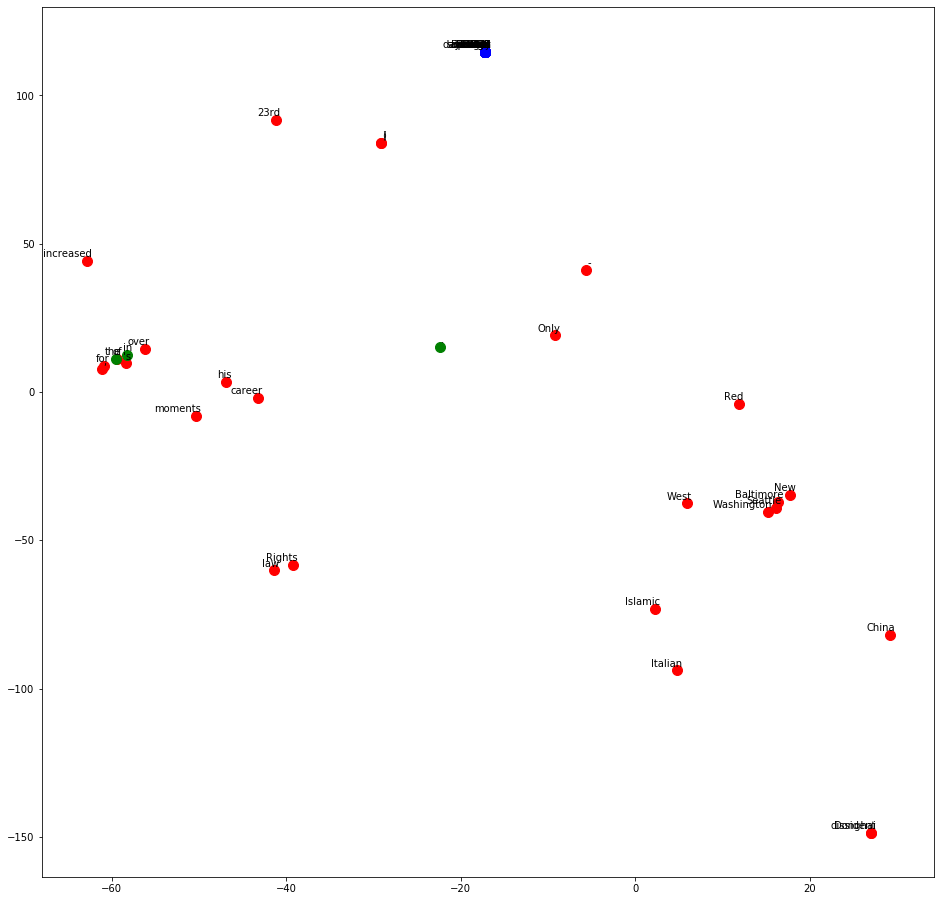

In [78]:
LIME_inaccurate_LOC_MISC_word_list, LIME_inaccurate_LOC_MISC_word_enity_list = get_word_entity_dict(LIME_top_n_words_inaccurate_LOC,
                                                                                          LIME_top_n_words_inaccurate_MISC,
                                                                                          'LOC', 'MISC')
tsne_plot(LIME_inaccurate_LOC_MISC_word_list, LIME_inaccurate_LOC_MISC_word_enity_list)

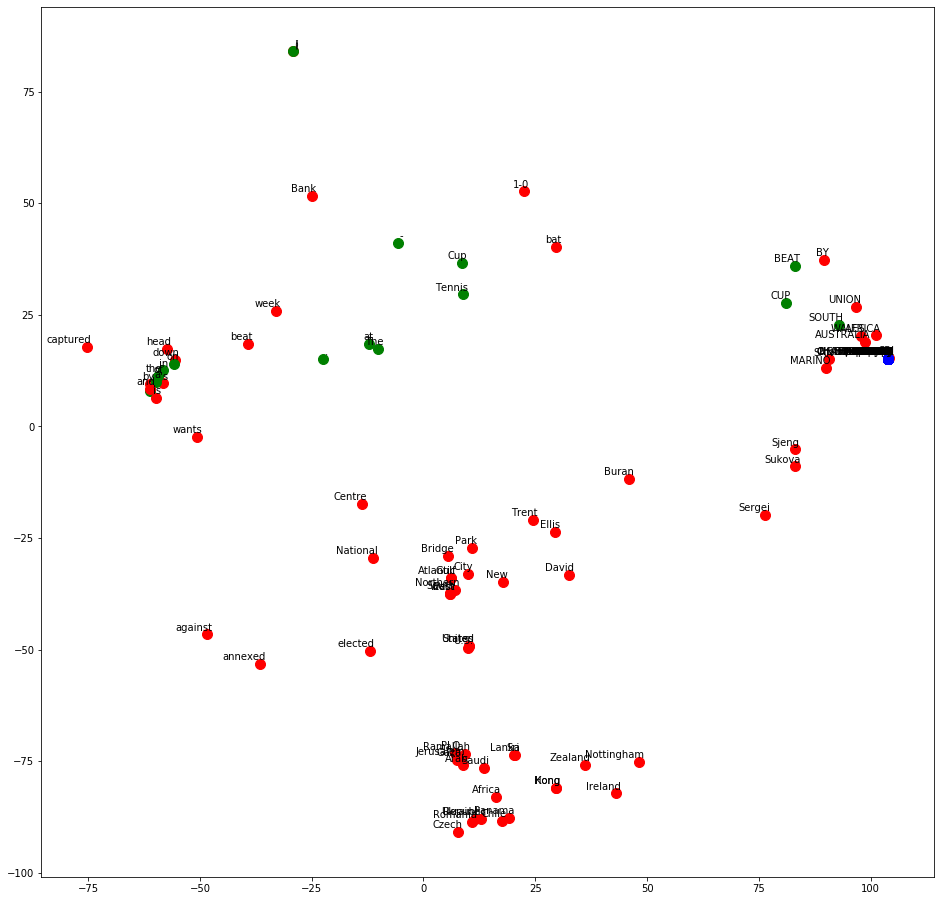

In [89]:
LIME_accurate_LOC_MISC_word_list, LIME_accurate_LOC_MISC_word_enity_list = get_word_entity_dict(LIME_top_n_words_accurate_LOC,
                                                                                          LIME_top_n_words_accurate_MISC,
                                                                                          'LOC', 'MISC')
tsne_plot(LIME_accurate_LOC_MISC_word_list, LIME_accurate_LOC_MISC_word_enity_list)

#### LIME vs KSHAP

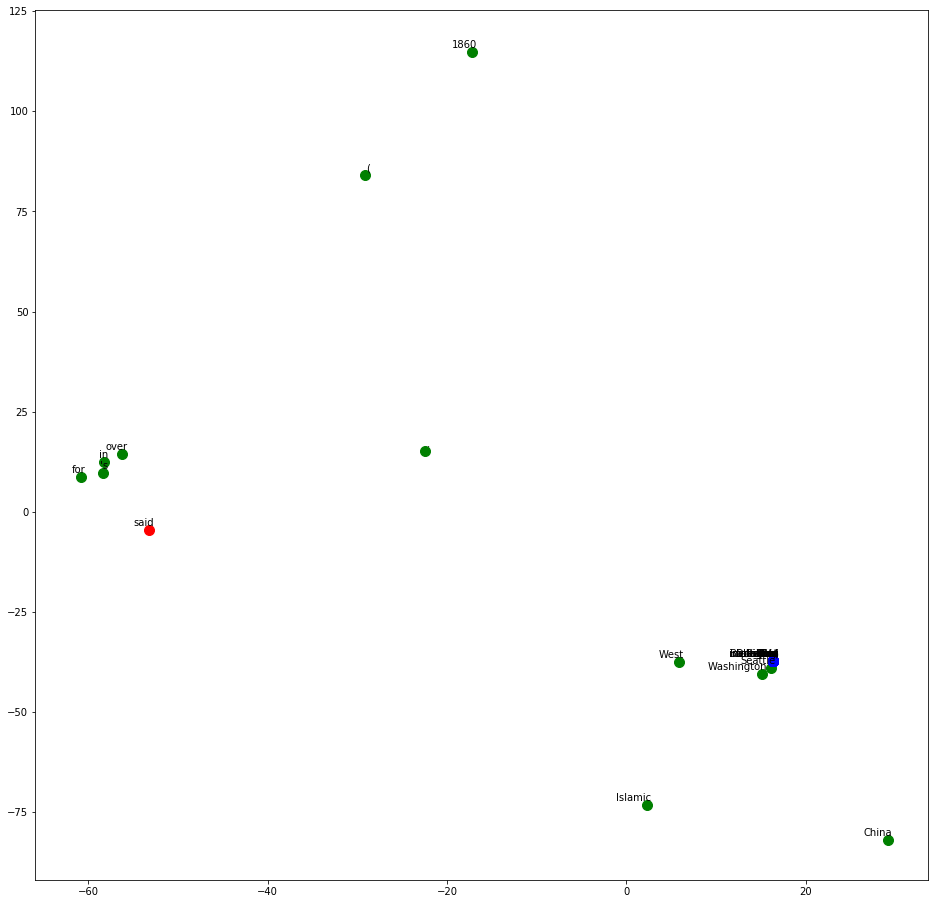

In [80]:
KSHAP_LIME_inaccurate_LOC_word_list, KSHAP_LIME_inaccurate_LOC_word_enity_list = get_word_entity_dict(KSHAP_top_n_words_inaccurate_LOC,
                                                                                          LIME_top_n_words_inaccurate_LOC,
                                                                                          'KSHAP', 'LIME')
tsne_plot(KSHAP_LIME_inaccurate_LOC_word_list, KSHAP_LIME_inaccurate_LOC_word_enity_list,
         cdict = {'KSHAP': 'red', 'LIME': 'blue', 'COMMON': 'green', None:'grey'})

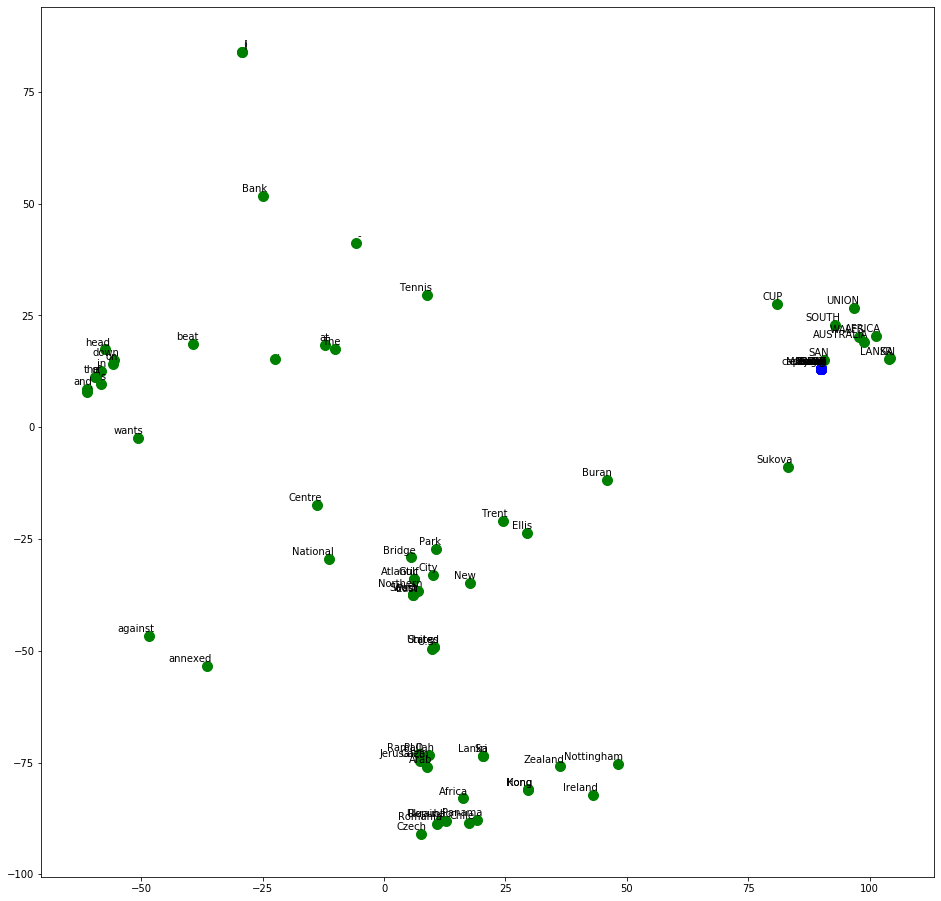

In [81]:
KSHAP_LIME_accurate_LOC_word_list, KSHAP_LIME_accurate_LOC_word_enity_list = get_word_entity_dict(KSHAP_top_n_words_accurate_LOC,
                                                                                          LIME_top_n_words_accurate_LOC,
                                                                                          'KSHAP', 'LIME')
tsne_plot(KSHAP_LIME_accurate_LOC_word_list, KSHAP_LIME_accurate_LOC_word_enity_list,
         cdict = {'KSHAP': 'red', 'LIME': 'blue', 'COMMON': 'green', None:'grey'})

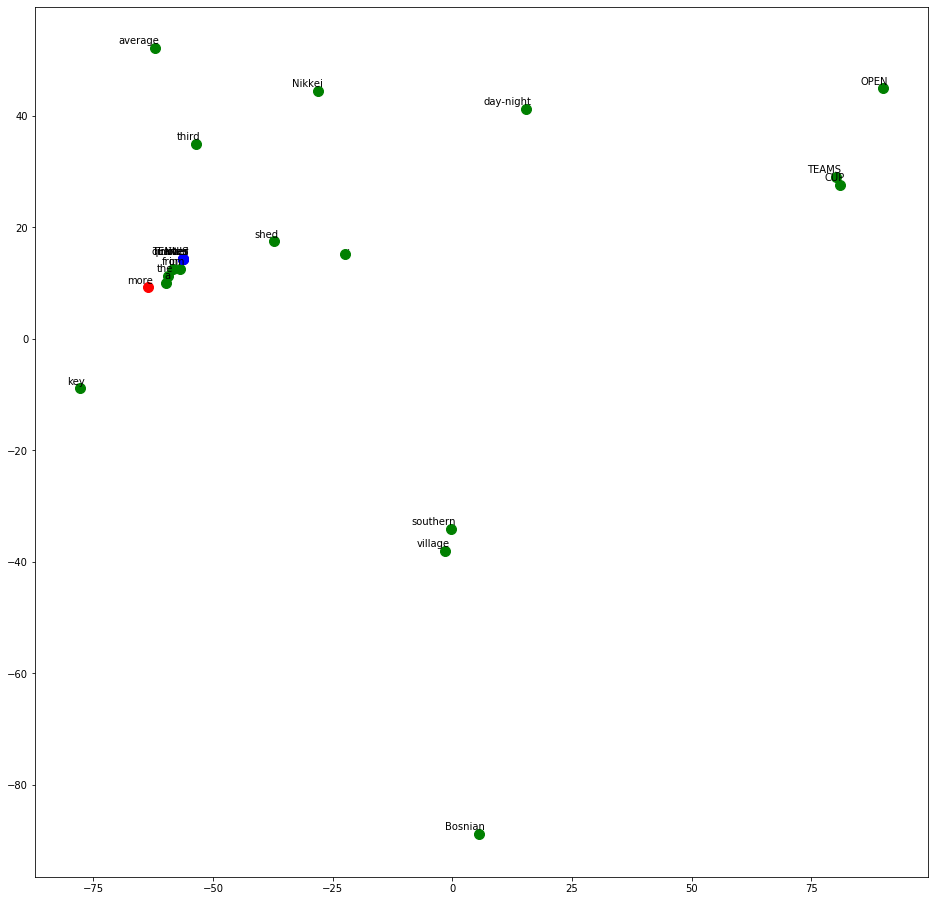

In [82]:
KSHAP_LIME_inaccurate_MISC_word_list, KSHAP_LIME_inaccurate_MISC_word_enity_list = get_word_entity_dict(KSHAP_top_n_words_inaccurate_MISC,
                                                                                          LIME_top_n_words_inaccurate_MISC,
                                                                                          'KSHAP', 'LIME')
tsne_plot(KSHAP_LIME_inaccurate_MISC_word_list, KSHAP_LIME_inaccurate_MISC_word_enity_list,
         cdict = {'KSHAP': 'red', 'LIME': 'blue', 'COMMON': 'green', None:'grey'})

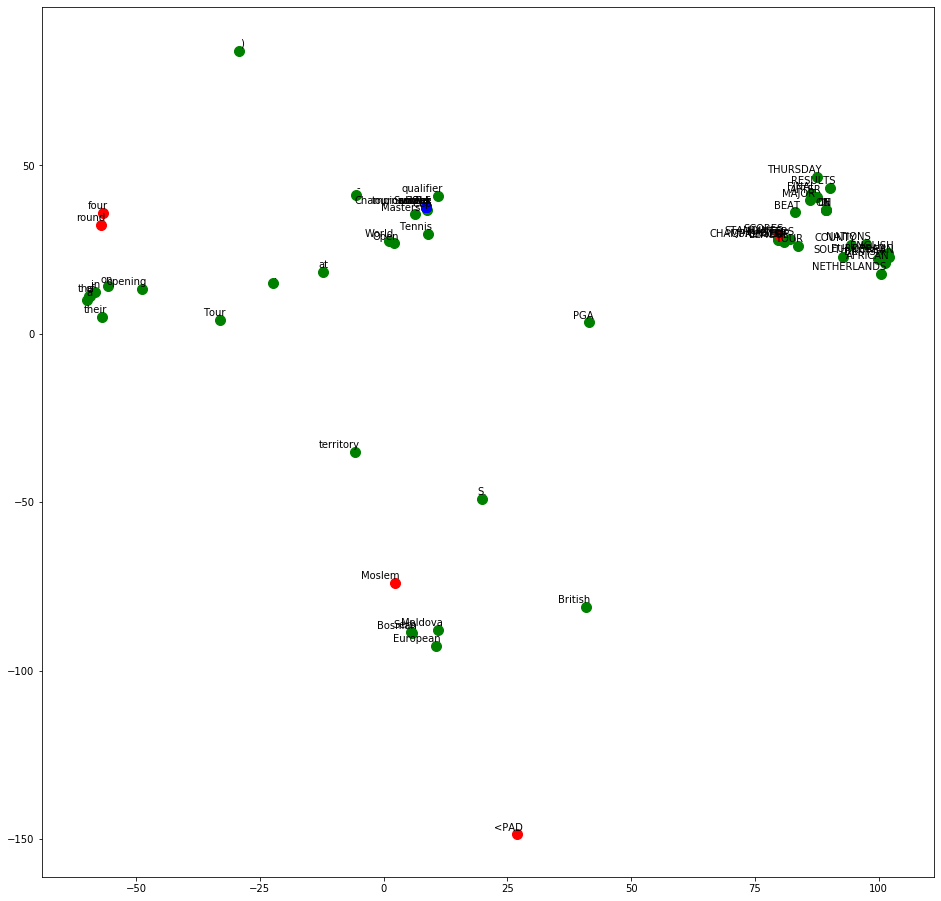

In [83]:
KSHAP_LIME_accurate_MISC_word_list, KSHAP_LIME_accurate_MISC_word_enity_list = get_word_entity_dict(KSHAP_top_n_words_accurate_MISC,
                                                                                          LIME_top_n_words_accurate_MISC,
                                                                                          'KSHAP', 'LIME')
tsne_plot(KSHAP_LIME_accurate_MISC_word_list, KSHAP_LIME_accurate_MISC_word_enity_list,
         cdict = {'KSHAP': 'red', 'LIME': 'blue', 'COMMON': 'green', None:'grey'})

#### Accurate vs Inaccurate

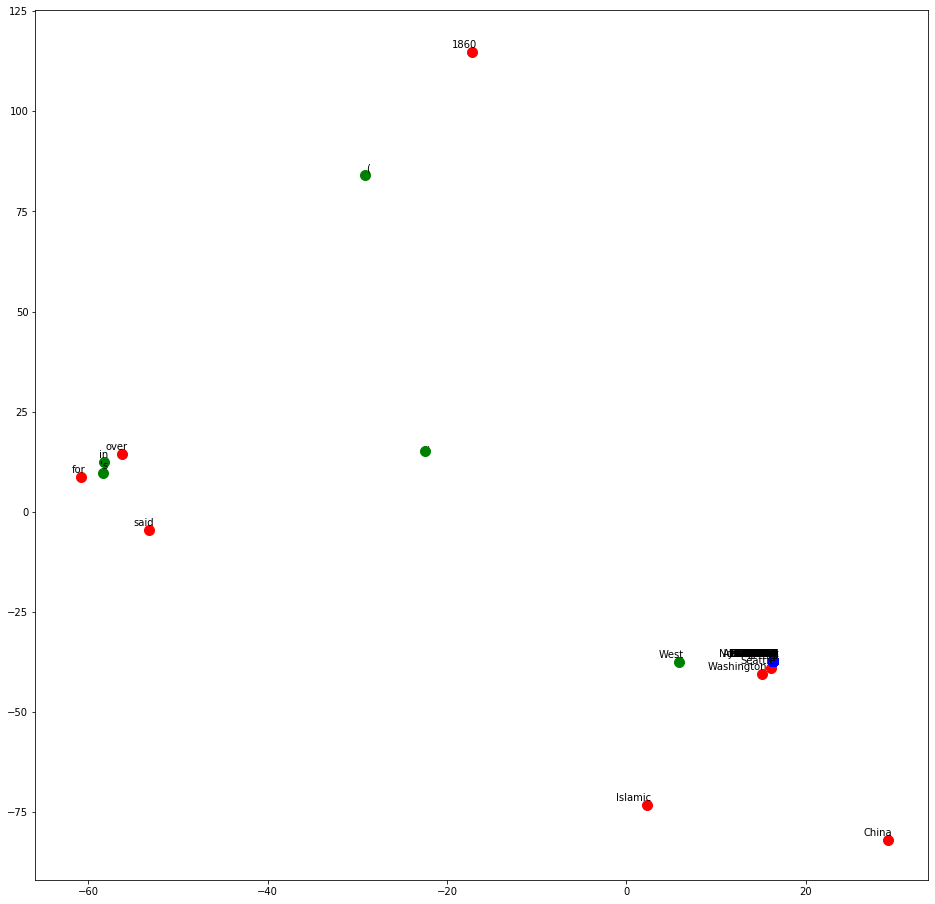

In [84]:
KSHAP_LOC_accurate_inaccurate_word_list, KSHAP_LOC_accurate_inaccurate_word_enity_list = get_word_entity_dict(KSHAP_top_n_words_inaccurate_LOC,
                                                                                                  KSHAP_top_n_words_accurate_LOC,
                                                                                                  'Inaccurate', 'Accurate')
tsne_plot(KSHAP_LOC_accurate_inaccurate_word_list, KSHAP_LOC_accurate_inaccurate_word_enity_list, 
          cdict = {'Inaccurate': 'red', 'Accurate': 'blue', 'COMMON': 'green', None:'grey'})

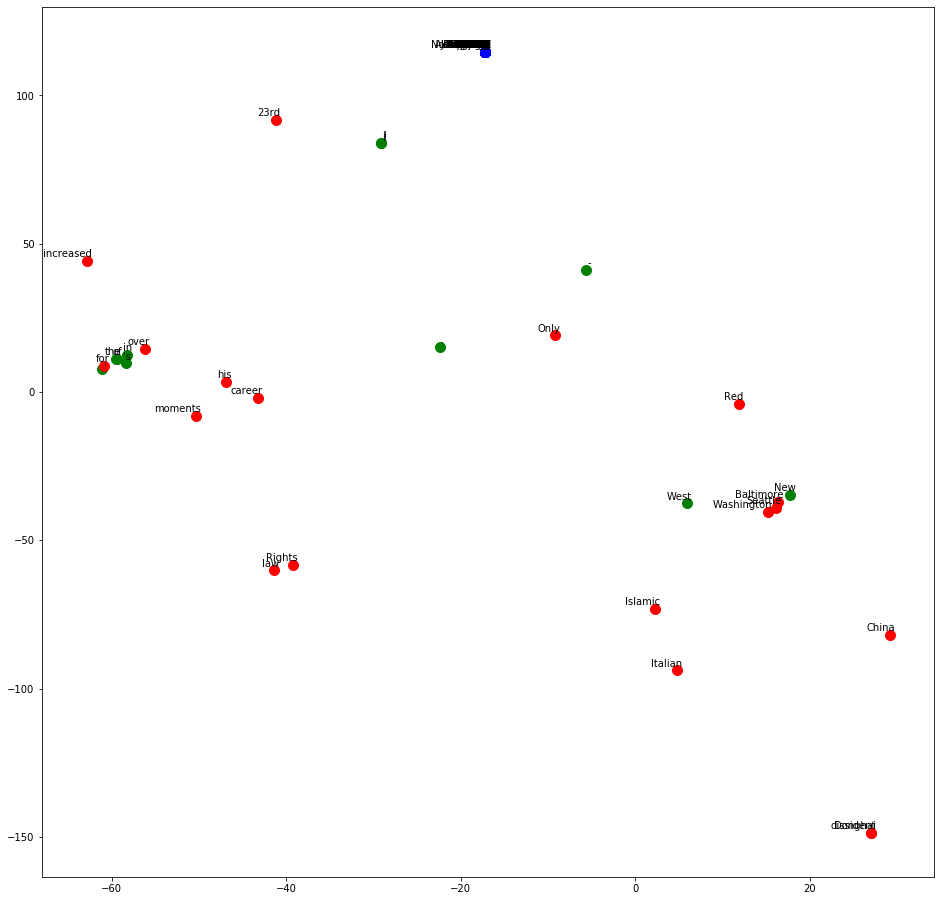

In [85]:
LIME_LOC_accurate_inaccurate_word_list, LIME_LOC_accurate_inaccurate_word_enity_list = get_word_entity_dict(LIME_top_n_words_inaccurate_LOC,
                                                                                                  LIME_top_n_words_accurate_LOC,
                                                                                                  'Inaccurate', 'Accurate')
tsne_plot(LIME_LOC_accurate_inaccurate_word_list, LIME_LOC_accurate_inaccurate_word_enity_list, 
          cdict = {'Inaccurate': 'red', 'Accurate': 'blue', 'COMMON': 'green', None:'grey'})

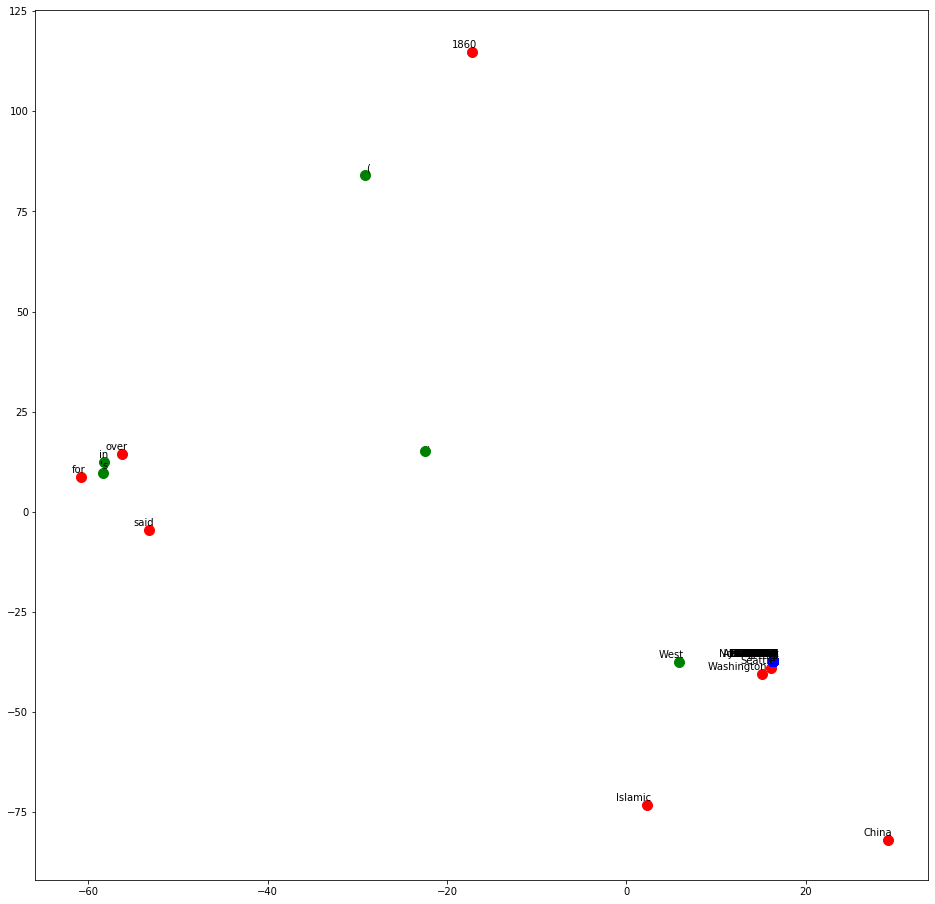

In [86]:
KSHAP_MISC_accurate_inaccurate_word_list, KSHAP_MISC_accurate_inaccurate_word_enity_list = get_word_entity_dict(KSHAP_top_n_words_inaccurate_LOC,
                                                                                                  KSHAP_top_n_words_accurate_LOC,
                                                                                                  'Inaccurate', 'Accurate')
tsne_plot(KSHAP_MISC_accurate_inaccurate_word_list, KSHAP_MISC_accurate_inaccurate_word_enity_list, 
          cdict = {'Inaccurate': 'red', 'Accurate': 'blue', 'COMMON': 'green', None:'grey'})

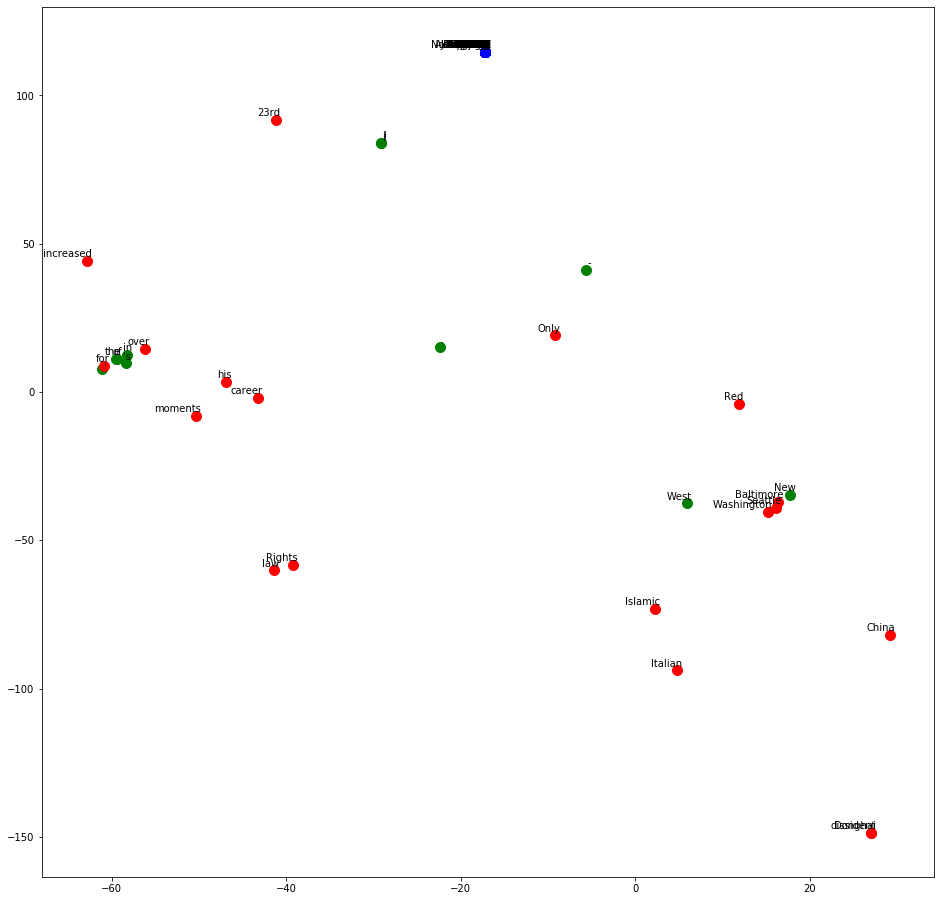

In [87]:
LIME_MISC_accurate_inaccurate_word_list, LIME_MISC_accurate_inaccurate_word_enity_list = get_word_entity_dict(LIME_top_n_words_inaccurate_LOC,
                                                                                                  LIME_top_n_words_accurate_LOC,
                                                                                                  'Inaccurate', 'Accurate')
tsne_plot(LIME_MISC_accurate_inaccurate_word_list, LIME_MISC_accurate_inaccurate_word_enity_list, 
          cdict = {'Inaccurate': 'red', 'Accurate': 'blue', 'COMMON': 'green', None:'grey'})